<a href="https://colab.research.google.com/github/lindsey5/Python-Practice/blob/main/xgboost_overallsales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [202]:
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (20, 10)  # for graphs styling
plt.style.use('tableau-colorblind10')  # for graph stying

In [203]:
main_df = pd.read_csv("Sample-Superstore.csv")
main_df['Order Date'] = pd.to_datetime(main_df['Order Date'])

# Group by Order Date and sum Sales
daily_sales = main_df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales.set_index('Order Date', inplace=True)
daily_sales.sort_index(inplace=True)
print("Daily Sales Data:")
print(daily_sales.head())
print("\n")

Daily Sales Data:
               Sales
Order Date          
2014-01-03    16.448
2014-01-04   288.060
2014-01-05    19.536
2014-01-06  4407.100
2014-01-07    87.158




In [204]:
daily_sales.describe()

,Sales
count,1237.000000
mean,1857.074261
std,2305.538776
min,2.025000
25%,377.736000
50%,1063.185000
75%,2395.786000
max,28106.716000


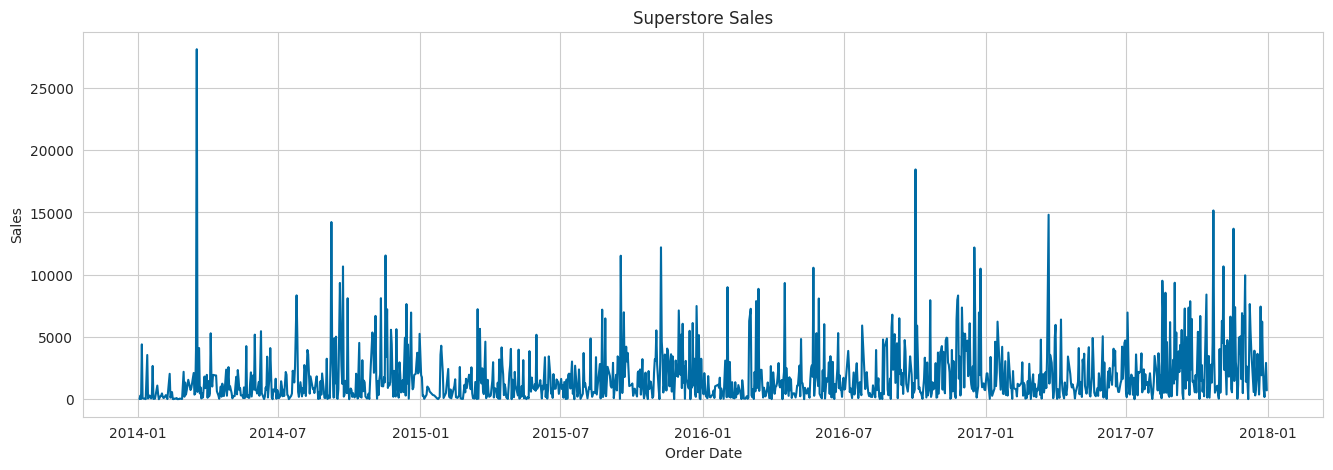

In [205]:
plt.figure(figsize=(16, 5))
plt.plot(daily_sales.index, daily_sales['Sales'])
plt.title('Superstore Sales')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.show()

In [206]:
def create_features(df):
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week


    # Add lag features
    for lag in [14, 30, 60]:
        df[f'lag_{lag}'] = df['Sales'].shift(lag)


    # Add difference features
    for lag in [30]:
        df[f'sales_diff_{lag}'] = df['Sales'] - df['Sales'].shift(lag)

    # Add rolling mean features
    for window in [30]:
        df[f'sales_rolling_mean_{window}'] = df['Sales'].rolling(window).mean()

    return df

df_with_features = daily_sales.copy()
df_with_features = create_features(df_with_features)

In [207]:
df_with_features.corr()

,Sales,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_14,lag_30,lag_60,sales_diff_30,sales_rolling_mean_30
Sales,1.000000,0.170633,0.013352,0.210996,0.241998,0.114746,0.239427,-0.021715,0.230346,0.072407,0.013683,0.066348,0.706352,0.284026
date,0.170633,1.000000,0.015715,0.228078,0.234884,0.969034,0.236737,0.022610,0.230603,0.168426,0.157694,0.131910,-0.001468,0.511346
dayofweek,0.013352,0.015715,1.000000,-0.009904,-0.017373,0.020796,-0.018148,-0.010323,-0.019243,-0.019101,-0.041777,-0.005169,0.042095,-0.009687
quarter,0.210996,0.228078,-0.009904,1.000000,0.970877,-0.011128,0.967388,0.001738,0.944243,0.187699,0.145683,-0.033052,0.038512,0.573891
month,0.241998,0.234884,-0.017373,0.970877,1.000000,-0.011503,0.996434,0.002694,0.968961,0.187494,0.125569,-0.025991,0.075146,0.585677
year,0.114746,0.969034,0.020796,-0.011128,-0.011503,1.000000,-0.010500,0.001220,-0.009287,0.125795,0.128329,0.138317,-0.019919,0.370908
dayofyear,0.239427,0.236737,-0.018148,0.967388,0.996434,-0.010500,1.000000,0.086771,0.970390,0.183370,0.125462,-0.024811,0.073281,0.587528
dayofmonth,-0.021715,0.022610,-0.010323,0.001738,0.002694,0.001220,0.086771,1.000000,0.059981,-0.048059,-0.003997,0.002044,-0.015769,0.024281
weekofyear,0.230346,0.230603,-0.019243,0.944243,0.968961,-0.009287,0.970390,0.059981,1.000000,0.179891,0.131085,-0.019956,0.062527,0.585715
lag_14,0.072407,0.168426,-0.019101,0.187699,0.187494,0.125795,0.183370,-0.048059,0.179891,1.000000,0.036675,0.044915,0.023524,0.342561


In [208]:
df = df_with_features[(df_with_features['Sales'] < 10000) & (df_with_features['Sales'] > 400)].copy()
df.dropna(inplace=True)
print(df.head())
print(df.dtypes)
print("Size of cleaned data:", df.size)

               Sales       date  dayofweek  quarter  month  year  dayofyear  \
Order Date                                                                    
2014-03-25   459.146 2014-03-25          1        1      3  2014         84   
2014-03-28  1823.804 2014-03-28          4        1      3  2014         87   
2014-03-29   890.841 2014-03-29          5        1      3  2014         88   
2014-03-30  1170.322 2014-03-30          6        1      3  2014         89   
2014-03-31  1959.552 2014-03-31          0        1      3  2014         90   

            dayofmonth  weekofyear    lag_14   lag_30    lag_60  \
Order Date                                                        
2014-03-25          25          13   705.562  129.568    16.448   
2014-03-28          28          13   741.956   21.360    19.536   
2014-03-29          29          13   918.314    9.040  4407.100   
2014-03-30          30          13  2108.550   54.208    87.158   
2014-03-31          31          14   370.782

In [209]:
# Split the data into training and testing sets
train_size = int(0.8 * len(df))
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

In [210]:
def split(df, label=None):
    # --- Features Selection ---
    X = df[[
        'dayofweek', 'quarter', 'month', 'year',
        'dayofyear', 'dayofmonth', 'weekofyear',

        'lag_14',
        'lag_30',
        'lag_60',

        'sales_diff_30',

        'sales_rolling_mean_30'
    ]]

    if label:
        y = df[label].reset_index(drop=True)
        return X, y
    return X

# Assuming train_df and test_df have a 'Sales' column
X_train, y_train = split(train_df.copy(), label='Sales')
X_test, y_test = split(test_df.copy(), label='Sales')

In [211]:
params = {
    'min_child_weight': [4, 5, 6],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [4, 5, 6, 7, 8],
}
# Initialize XGB and GridSearch
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)
grid = GridSearchCV(xgb_reg, params, cv=2) # Reduced cv for faster execution
grid.fit(X_train, y_train)
gridcv_xgb = grid.best_estimator_
r2 = r2_score(y_test, gridcv_xgb.predict(X_test))
print(f"\nR2 score on the test set: {r2}")


R2 score on the test set: 0.9534719264250662


<Figure size 1200x600 with 0 Axes>

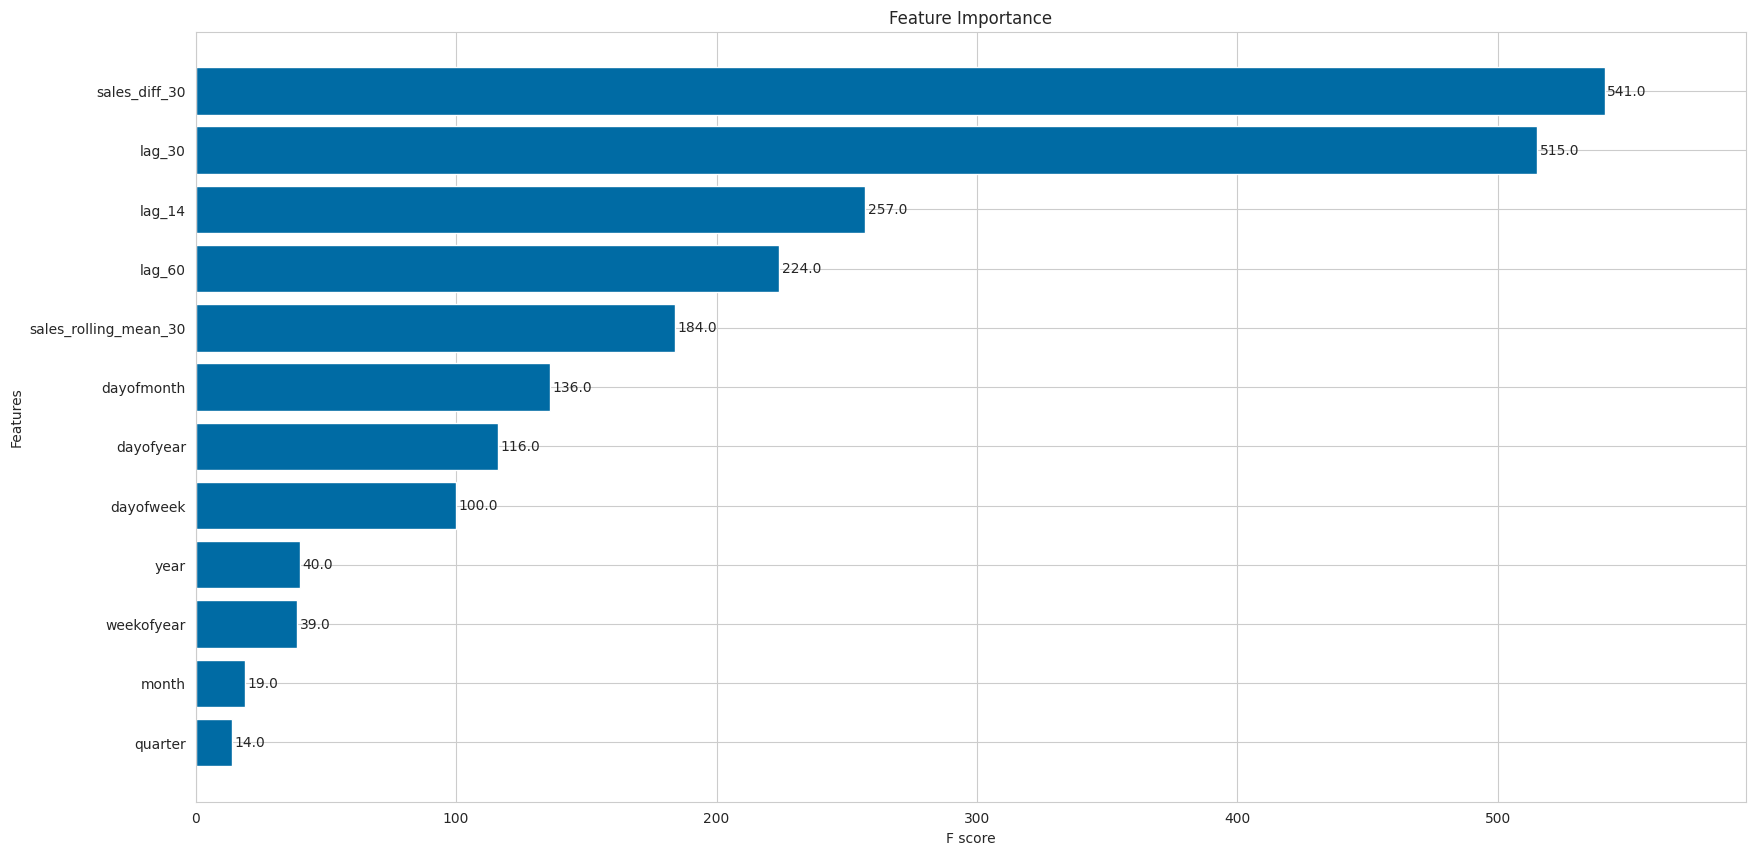

In [212]:
plt.figure(figsize=(12, 6))
xgb.plot_importance(gridcv_xgb, height=0.8)
plt.title('Feature Importance')
plt.show()

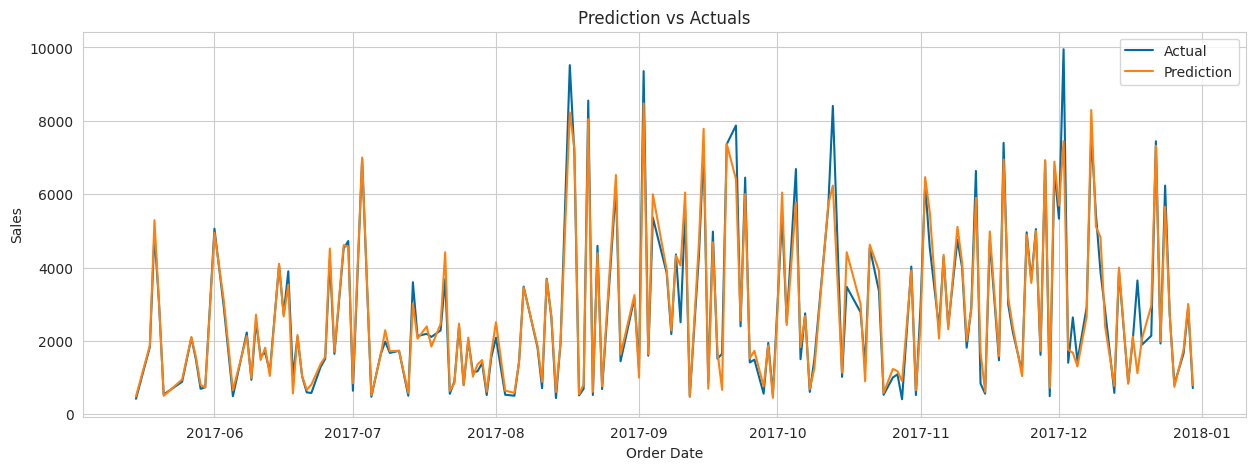


Mean Absolute Percentage Error (MAPE): 12.22%


In [219]:
test_df['Prediction'] = gridcv_xgb.predict(X_test)
df_all = pd.concat([train_df, test_df], sort=False)

plt.figure(figsize=(15, 5))
plt.plot(df_all['Sales'][- len(test_df['Prediction']):], label='Actual')
plt.plot(test_df['Prediction'], label='Prediction')
plt.title('Prediction vs Actuals')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true=test_df['Sales'], y_pred=test_df['Prediction'])
print(f"\nMean Absolute Percentage Error (MAPE): {mape:.2f}%")

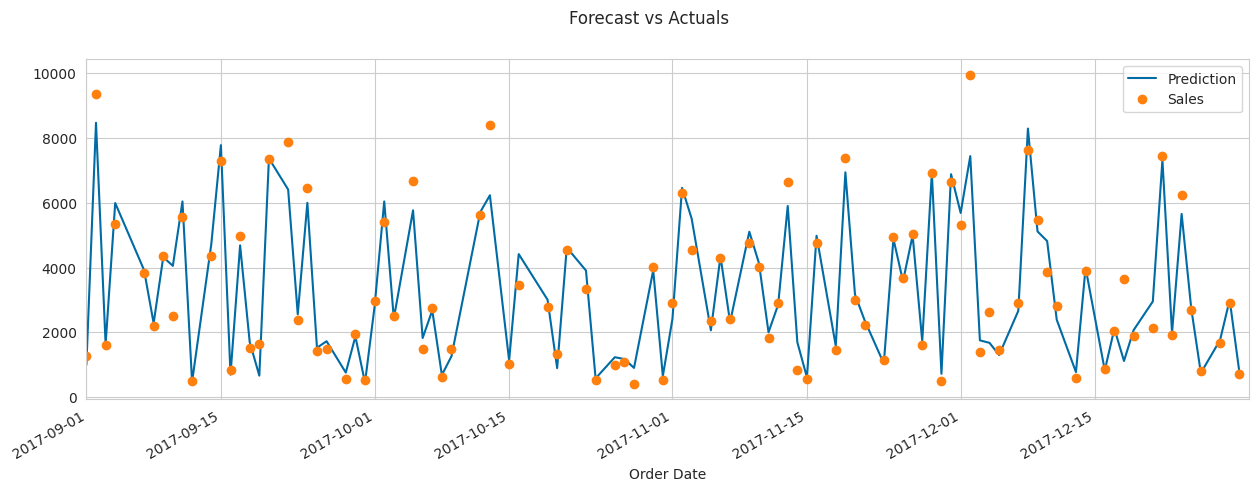

In [214]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['Prediction','Sales']].plot(ax=ax, style=['-', 'o'])
ax.set_xbound(lower='2017-09-01', upper='2017-12-31')
plot = plt.suptitle('Forecast vs Actuals')
plt.show()

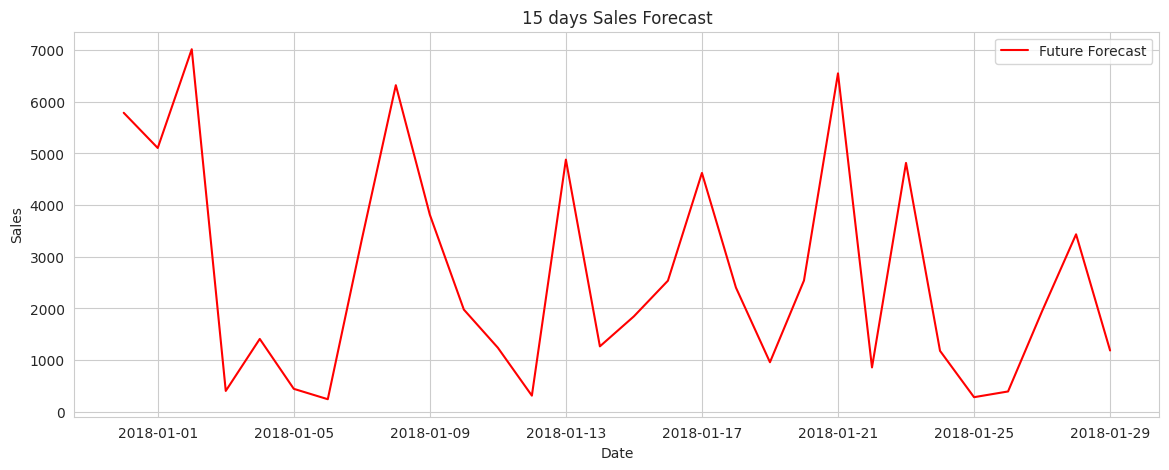

In [224]:
import datetime

future_dates = pd.date_range(start=df_all.index.max() + pd.Timedelta(days=1), periods=30, freq='D')
future_predictions = []
combined_sales = list(df_with_features['Sales'].iloc[-60:])


for date in future_dates:
    new_row = pd.DataFrame(index=[date])
    new_row['dayofweek'] = date.dayofweek
    new_row['quarter'] = date.quarter
    new_row['month'] = date.month
    new_row['year'] = date.year
    new_row['dayofyear'] = date.dayofyear
    new_row['dayofmonth'] = date.day
    new_row['weekofyear'] = date.isocalendar().week

    # Lags
    new_row['lag_14'] = combined_sales[-14]
    new_row['lag_30'] = combined_sales[-30] if len(combined_sales) >= 30 else combined_sales[-1]
    new_row['lag_60'] = combined_sales[-60] if len(combined_sales) >= 60 else combined_sales[-1]

    # Differences
    new_row['sales_diff_30'] = combined_sales[-1] - combined_sales[-31]

    # Rolling Means
    new_row['sales_rolling_mean_30'] = pd.Series(combined_sales[-30:]).mean()

    # Predict and update
    pred_sales = gridcv_xgb.predict(new_row)[0]
    future_predictions.append(pred_sales)
    combined_sales.append(pred_sales)

# Build forecast DataFrame
future_df = pd.DataFrame({
    'Date': future_dates,
    'xgb_Prediction': future_predictions
}).set_index('Date')

# Plot forecast
plt.figure(figsize=(14, 5))
plt.plot(future_df['xgb_Prediction'], color='red', label='Future Forecast')
plt.title('30 days Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [223]:
future_df['xgb_Prediction']

,xgb_Prediction
Date,
2017-12-31,5786.104980
2018-01-01,5104.883301
2018-01-02,7016.003418
2018-01-03,404.305786
2018-01-04,1410.287231
2018-01-05,444.654663
2018-01-06,243.668976
2018-01-07,3334.194580
2018-01-08,6320.109375


In [217]:
import pickle

# Save the model
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(gridcv_xgb, file)